In [1]:
#####################################################################
# This notebook is authored by: Ayan Paul                           #
# Date: November 2020                                               #
# If you use this code or the results from this work please cite:   # 
# Resurrecting bbh with kinematic shapes                            #
# Christophe Grojean, Ayan Paul and Zuoni Qian                      #
# arXiv:2011.13945 (https://arxiv.org/abs/2011.13945)               # 
#####################################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import cmath
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.optimize import fsolve
import scipy.optimize as opt
import sys

# To supress warnings from seaborn
if not sys.warnoptions:
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib import rc
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams['font.family'] = 'monospace'

In [2]:
def fileparser(path, dlist, weights=True):
    df = pd.read_csv(path)
    df.drop(columns=dlist, inplace=True)    
    n = len(df)
    if weights: weight = int(round(np.mean(np.abs(df['weight'].to_numpy())) * 6 * 1e6 * n))
    else: weight = int(round(np.abs(df['weight'].mean()) * 6. * 1e3)) ## REMEMBER: Weight is put by hand in the root file and is just the XS in fb.
    df['weight'] = df['weight']
    return df, weight

In [5]:
dlist = ['dphibb', 'etaaa', 'ptb2', 'drbamin', 'met', 'etaa2', 'etab1', 'etaa1', 'nbjet', 'etab2']

# 14 TeV
df_hhsm, weight_hhsm = fileparser("../simulations/HL-LHC/hhsm.csv", dlist, weights=True)
df_ku_1, weight_ku = fileparser("../simulations/HL-LHC/ku-1.csv", dlist, weights=False)
df_ku_2, weight_ku = fileparser("../simulations/HL-LHC/ku-2.csv", dlist, weights=False)
df_tth, weight_tth = fileparser("../simulations/HL-LHC/tth.csv", dlist, weights=False)
df_yb2, weight_yb2 = fileparser("../simulations/HL-LHC/yb2.csv", dlist)
df_ybyt, weight_ybyt = fileparser("../simulations/HL-LHC/ybyt.csv", dlist)
df_yt2, weight_yt2 = fileparser("../simulations/HL-LHC/yt2.csv", dlist)
df_zh, weight_zh = fileparser("../simulations/HL-LHC/zh.csv", dlist)
df_bbxaa, weight_bbxaa = fileparser("../simulations/HL-LHC/bbxaa.csv", dlist)

df_bbh = pd.concat([df_yb2, df_ybyt, df_yt2, df_zh])
weight_bbh = int(weight_yb2*1.5 - weight_ybyt*1.9 + weight_yt2*2.5 + weight_zh*1.3)

df_ku = pd.concat([df_ku_1, df_ku_2])

print("No. of hhsm events: train = {}".format(df_hhsm.shape[0]))
print("No. of ku events: train = {}".format(df_ku.shape[0]))
print("No. of tth events: train = {}".format(df_tth.shape[0]))
print("No. of bbh events: train = {}".format(df_bbh.shape[0]))
print("No. of bbxaa events: train = {}".format(df_bbxaa.shape[0]))

No. of hhsm events: train = 48436
No. of ku events: train = 77882
No. of tth events: train = 57848
No. of bbh events: train = 365876
No. of bbxaa events: train = 137488


In [ ]:
df_plot_yb2 = df_yb2
df_plot_zh = df_zh
df_plot = pd.concat([df_plot_yb2, df_plot_zh], axis=0)

sns.set(font_scale=1.5, style='ticks')

def makeJoint(var, lim, names):
    xlim = lim[0]
    ylim = lim[1]
    g = sns.JointGrid(marginal_ticks=True, height=7, ratio=3, xlim = (0,xlim), ylim = (0,ylim))
    g.ax_joint.grid(linestyle=':')

    x, y = df_plot[(df_plot['class']==1) & (df_plot[var[0]] < xlim)][var[0]], df_plot[(df_plot['class']==1) & (df_plot[var[1]] < ylim)][var[1]]
    weightx, weighty = df_plot[(df_plot['class']==1) & (df_plot[var[0]] < xlim)]['weight'], df_plot[(df_plot['class']==1) & (df_plot[var[1]] < ylim)]['weight']
    sns.kdeplot(x=x, y=y, color='#3f7f93', ax=g.ax_joint)
    sns.distplot(x=x, kde=False, bins=50, hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': weightx * 6 * 1e6 * 1.3},
                 color='#3f7f93', ax=g.ax_marg_x)
    sns.distplot(x=y, kde=False,  bins=50, vertical=True, hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': weighty * 6 * 1e6 * 1.3},
                 color='#3f7f93', ax=g.ax_marg_y)

    x, y = df_plot[(df_plot['class']==4) & (df_plot[var[0]] < xlim)][var[0]], df_plot[(df_plot['class']==4) & (df_plot[var[1]] < ylim)][var[1]]
    weightx, weighty = df_plot[(df_plot['class']==4) & (df_plot[var[0]] < xlim)]['weight'], df_plot[(df_plot['class']==4) & (df_plot[var[1]] < ylim)]['weight']
    sns.kdeplot(x=x, y=y, color='#da3b46', ax=g.ax_joint)
    sns.distplot(x=x, kde=False, bins=50, hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': weightx * 6 * 1e6 * 1.5},
                 color='#da3b46', ax=g.ax_marg_x)
    sns.distplot(x=y, kde=False, bins=50, vertical=True, hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': weighty * 6 * 1e6 * 1.5},
                 color='#da3b46', ax=g.ax_marg_y)

    g.set_axis_labels(names[0], names[1], fontsize=20)
    phantom1, = g.ax_joint.plot([], [], linestyle="-", alpha=1, color='#3f7f93', linewidth=3)
    phantom2, = g.ax_joint.plot([], [], linestyle="-", alpha=1, color='#da3b46', linewidth=3)
    g.ax_joint.legend([phantom1, phantom2],[r'$Zh$', r'$y_b^2$'])
    return plt
    
var=["mb1h", "ptaa"]
lim=[750, 450]
names=[r'$m_{b_1h} \;\rm [GeV]$', r'$p_{T}^{\gamma\gamma} \;\rm [GeV]$']
plt = makeJoint(var, lim, names)
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.savefig('../plots/shape-mb1h-ptaa.pdf', dpi=300)
plt.show()

var=["mb1h", "ptb1"]
lim=[750, 325]
names=[r'$m_{b_1h} \;\rm [GeV]$', r'$p_{T}^{b_1} \;\rm [GeV]$']
plt = makeJoint(var, lim, names)
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.savefig('../plots/shape-mb1h-ptb1.pdf', dpi=300)
plt.show()

var=["mb1h", "mbb"]
lim=[750, 150]
names=[r'$m_{b_1h} \;\rm [GeV]$', r'$m_{bb} \;\rm [GeV]$']
makeJoint(var, lim, names)
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.savefig('../plots/shape-mb1h-mbb.pdf', dpi=300)
plt.show()

var=["mb1h", "ht"]
lim=[750, 1000]
names=[r'$m_{b_1h} \;\rm [GeV]$', r'$H_T \;\rm [GeV]$']
makeJoint(var, lim, names)
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.savefig('../plots/shape-mb1h-ht.pdf', dpi=300)
plt.show()


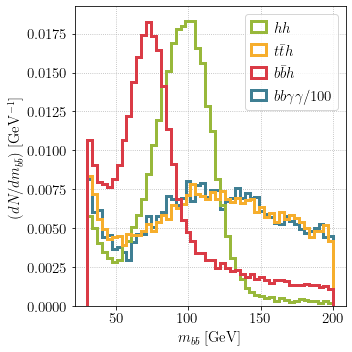

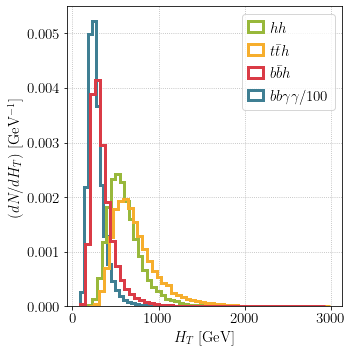

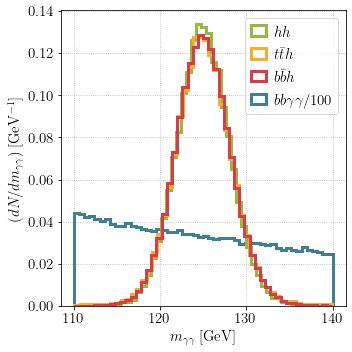

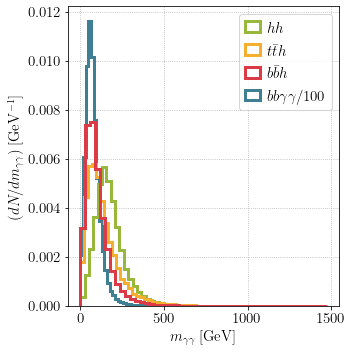

In [6]:
density = True
fact = 1
plt.figure(figsize=(5,5))
plt.hist(df_hhsm[(df_hhsm.mbb < 200) & (df_hhsm.mbb > 30)].mbb, bins=50, histtype='step', linewidth=3, label=r'$hh$', weights=df_hhsm[(df_hhsm.mbb < 200) & (df_hhsm.mbb > 30)]['weight'] * 6 * 1e3 * 1.72/df_hhsm[(df_hhsm.mbb < 200) & (df_hhsm.mbb > 30)]['weight'].shape[0], density=density, color='#98b83b', zorder=100)
plt.hist(df_tth[(df_tth.mbb < 200) & (df_tth.mbb > 30)].mbb, bins=50, histtype='step', linewidth=3, label=r'$t\bar{t}h$', weights=df_tth[(df_tth.mbb < 200) & (df_tth.mbb > 30)]['weight'] * 6 * 1e3 * 1.2/df_tth[(df_tth.mbb < 200) & (df_tth.mbb > 30)]['weight'].shape[0], density=density, color='#F6AE2D', zorder=100)
plt.hist(df_bbh[(df_bbh.mbb < 200) & (df_bbh.mbb > 30)].mbb, bins=50, histtype='step', linewidth=3, label=r'$b\bar{b}h$', weights=df_bbh[(df_bbh.mbb < 200) & (df_bbh.mbb > 30)]['weight'] * 6 * 1e6, density=density, color='#da3b46', zorder=100)
plt.hist(df_bbxaa[(df_bbxaa.mbb < 200) & (df_bbxaa.mbb > 30)].mbb, bins=50, histtype='step', linewidth=3, label=r'$bb\gamma\gamma/100$', weights=df_bbxaa[(df_bbxaa.mbb < 200) & (df_bbxaa.mbb > 30)]['weight'] * 6 * 1e6 * 1.5/fact, density=density, color='#3f7f93')
plt.grid(linestyle=':')
plt.xlabel(r'$m_{b\bar{b}} \;\rm [GeV]$', fontsize=15)
plt.ylabel(r'$(dN/dm_{b\bar{b}}) \;\rm [GeV^{-1}]$', fontsize=15)
plt.legend(fontsize=15, ncol=1, columnspacing=0.5, handlelength=1, handletextpad=0.5, loc='upper right')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.savefig('../plots/mbb-3-channel.pdf', dpi=300)
plt.show()

plt.figure(figsize=(5,5))
plt.hist(df_hhsm[df_hhsm.ht < 3000].ht, bins=50, histtype='step', linewidth=3, label=r'$hh$', weights=df_hhsm[df_hhsm.ht < 3000]['weight'] * 6 * 1e3 * 1.72/df_hhsm[df_hhsm.ht < 3000]['weight'].shape[0], density=density, color='#98b83b', zorder=100)
plt.hist(df_tth[df_tth.ht < 3000].ht, bins=50, histtype='step', linewidth=3, label=r'$t\bar{t}h$', weights=df_tth[df_tth.ht < 3000]['weight'] * 6 * 1e3 * 1.2/df_tth[df_tth.ht < 3000]['weight'].shape[0], density=density, color='#F6AE2D', zorder=100)
plt.hist(df_bbh[df_bbh.ht < 3000].ht, bins=50, histtype='step', linewidth=3, label=r'$b\bar{b}h$', weights=df_bbh[df_bbh.ht < 3000]['weight'] * 6 * 1e6, density=density, color='#da3b46', zorder=100)
plt.hist(df_bbxaa[df_bbxaa.ht < 3000].ht, bins=50, histtype='step', linewidth=3, label=r'$bb\gamma\gamma/100$', weights=df_bbxaa[df_bbxaa.ht < 3000]['weight'] * 6 * 1e6 * 1.5/fact, density=density, color='#3f7f93')
plt.grid(linestyle=':')
plt.xlabel(r'$H_{T} \;\rm [GeV]$', fontsize=15)
plt.ylabel(r'$(dN/dH_{T}) \;\rm [GeV^{-1}]$', fontsize=15)
plt.legend(fontsize=15, ncol=1, columnspacing=0.5, handlelength=1, handletextpad=0.5, loc='upper right')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.savefig('../plots/ht-3-channel.pdf', dpi=300)
plt.show()

plt.figure(figsize=(5,5))
plt.hist(df_hhsm.maa, bins=50, histtype='step', linewidth=3, label=r'$hh$', weights=df_hhsm['weight'] * 6 * 1e3 * 1.72/df_hhsm['weight'].shape[0], density=density, color='#98b83b', zorder=100)
plt.hist(df_tth.maa, bins=50, histtype='step', linewidth=3, label=r'$t\bar{t}h$', weights=df_tth['weight'] * 6 * 1e3 * 1.2/df_tth['weight'].shape[0], density=density, color='#F6AE2D', zorder=100)
plt.hist(df_bbh.maa, bins=50, histtype='step', linewidth=3, label=r'$b\bar{b}h$', weights=df_bbh['weight'] * 6 * 1e6, density=density, color='#da3b46', zorder=100)
plt.hist(df_bbxaa.maa, bins=50, histtype='step', linewidth=3, label=r'$bb\gamma\gamma/100$', weights=df_bbxaa['weight'] * 6 * 1e6 * 1.5/fact, density=density, color='#3f7f93')
plt.grid(linestyle=':')
plt.xlabel(r'$m_{\gamma\gamma} \;\rm [GeV]$', fontsize=15)
plt.ylabel(r'$(dN/dm_{\gamma\gamma}) \;\rm [GeV^{-1}]$', fontsize=15)
plt.legend(fontsize=15, ncol=1, columnspacing=0.5, handlelength=1, handletextpad=0.5, loc='upper right')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.savefig('../plots/maa-3-channel.pdf', dpi=300)
plt.show()

plt.figure(figsize=(5,5))
plt.hist(df_hhsm.ptaa, bins=50, histtype='step', linewidth=3, label=r'$hh$', weights=df_hhsm['weight'] * 6 * 1e3 * 1.72/df_hhsm['weight'].shape[0], density=density, color='#98b83b', zorder=100)
plt.hist(df_tth.ptaa, bins=50, histtype='step', linewidth=3, label=r'$t\bar{t}h$', weights=df_tth['weight'] * 6 * 1e3 * 1.2/df_tth['weight'].shape[0], density=density, color='#F6AE2D', zorder=100)
plt.hist(df_bbh.ptaa, bins=50, histtype='step', linewidth=3, label=r'$b\bar{b}h$', weights=df_bbh['weight'] * 6 * 1e6, density=density, color='#da3b46', zorder=100)
plt.hist(df_bbxaa.ptaa, bins=50, histtype='step', linewidth=3, label=r'$bb\gamma\gamma/100$', weights=df_bbxaa['weight'] * 6 * 1e6 * 1.5/fact, density=density, color='#3f7f93')
plt.grid(linestyle=':')
plt.xlabel(r'$m_{\gamma\gamma} \;\rm [GeV]$', fontsize=15)
plt.ylabel(r'$(dN/dm_{\gamma\gamma}) \;\rm [GeV^{-1}]$', fontsize=15)
plt.legend(fontsize=15, ncol=1, columnspacing=0.5, handlelength=1, handletextpad=0.5, loc='upper right')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.savefig('../plots/maa-3-channel.pdf', dpi=300)
plt.show()

# plt.figure(figsize=(5,5))
# # plt.hist(df_hhsm.etab2, bins=50, histtype='step', linewidth=3, label=r'$hh$', weights=df_hhsm['weight'] * 6 * 1e3 * 1.72/df_hhsm['weight'].shape[0], density=density, color='#98b83b', zorder=100)
# plt.hist(df_bbh.etab2, bins=50, histtype='step', linewidth=3, label=r'$b\bar{b}h$', weights=df_bbh['weight'] * 6 * 1e6 * 1.5, density=density, color='#da3b46', zorder=100)
# plt.hist(df_bbxaa.etab2, bins=50, histtype='step', linewidth=3, label=r'$bb\gamma\gamma/100$', weights=df_bbxaa['weight'] * 6 * 1e6 * 1.5/fact, density=density, color='#3f7f93')
# plt.grid(linestyle=':')
# plt.xlabel(r'$\eta_{b_2} \;\rm [GeV]$', fontsize=15)
# plt.ylabel(r'$(dN/d\eta_{b_2}) \;\rm [GeV^{-1}]$', fontsize=15)
# plt.legend(fontsize=15, ncol=1, columnspacing=0.5, handlelength=1, handletextpad=0.5, loc='upper right')
# ax = plt.gca()
# ax.tick_params(axis='both', which='major', labelsize=15)
# plt.tight_layout()
# plt.savefig('../plots/etab2-3-channel.pdf', dpi=300)
# plt.show()

In [14]:
np.savetxt("../simulations/Correlations/yb2.txt", df_yb2.iloc[:,:-2].corr().values, fmt="%s")

In [15]:
np.savetxt("../simulations/Correlations/zh.txt", df_zh.iloc[:,:-2].corr().values, fmt="%s")

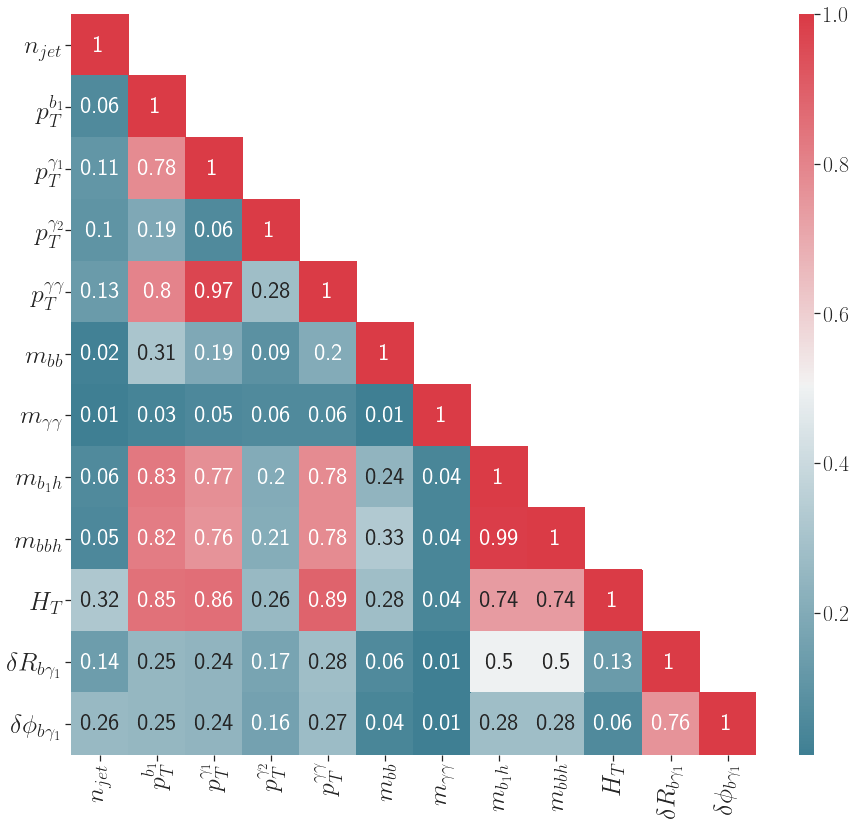

In [6]:
df_corr = df_hhsm.iloc[:,:-2].corr()

var = [r'$n_{jet}$', r'$p_T^{b_1}$', r'$p_T^{\gamma_1}$', r'$p_T^{\gamma_2}$', r'$p_T^{\gamma\gamma}$', r'$m_{bb}$', r'$m_{\gamma\gamma}$', r'$m_{b_1h}$', r'$m_{bbh}$',
       r'$H_T$', r'$\delta R_{b\gamma_1}$', r'$\delta\phi_{b\gamma_1}$']
    
fig, ax = plt.subplots(figsize=(13.5, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros((df_corr.shape[1],df_corr.shape[1]))
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask,0)
heat = sns.heatmap(round(np.abs(df_corr), 2)+0., mask=mask, annot=True, cmap=cmap, cbar_kws={"aspect": 50}, xticklabels=var, yticklabels=var,
                   annot_kws={"fontsize": 24})
ax = plt.gca()
sns.set(font_scale=2., style='ticks')
heat.set_xticklabels(heat.get_xmajorticklabels(), fontsize = 26, rotation=90)
heat.set_yticklabels(heat.get_ymajorticklabels(), fontsize = 26, rotation=0)
plt.tight_layout()
plt.savefig('../plots/corr-hhsm.png', dpi=300)

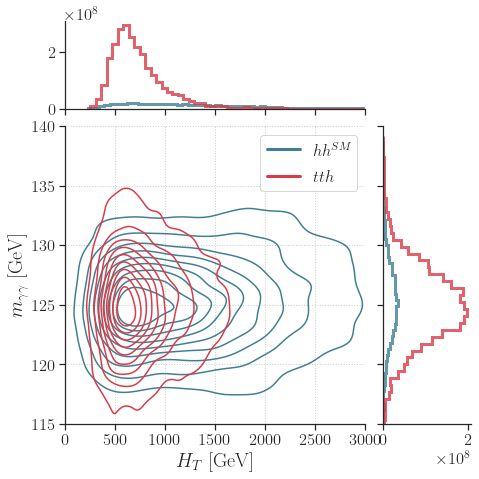

In [18]:
df_plot_hhsm = df_hhsm.sample(n=5000)
df_plot_hhsm['class'] = 1
df_plot_tth = df_tth.sample(n=5000)
df_plot_tth['class'] = 4
df_plot = pd.concat([df_plot_hhsm, df_plot_tth], axis=0)

sns.set(font_scale=1.5, style='ticks')

def makeJoint(var, lim, names):
    xlim = lim[0]
    ylim = lim[1]
    g = sns.JointGrid(marginal_ticks=True, height=7, ratio=3, xlim = (0,xlim), ylim = (115,140))
    g.ax_joint.grid(linestyle=':')

    x, y = df_plot[(df_plot['class']==1) & (df_plot[var[0]] < xlim)][var[0]], df_plot[(df_plot['class']==1) & (df_plot[var[1]] < ylim)][var[1]]
    weightx, weighty = df_plot[(df_plot['class']==1) & (df_plot[var[0]] < xlim)]['weight'], df_plot[(df_plot['class']==1) & (df_plot[var[1]] < ylim)]['weight']
    sns.kdeplot(x=x, y=y, color='#3f7f93', ax=g.ax_joint)
    sns.distplot(x=x, kde=False, bins=50, hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': weightx * 6 * 1e6 * 1.3},
                 color='#3f7f93', ax=g.ax_marg_x)
    sns.distplot(x=y, kde=False,  bins=50, vertical=True, hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': weighty * 6 * 1e6 * 1.3},
                 color='#3f7f93', ax=g.ax_marg_y)

    x, y = df_plot[(df_plot['class']==4) & (df_plot[var[0]] < xlim)][var[0]], df_plot[(df_plot['class']==4) & (df_plot[var[1]] < ylim)][var[1]]
    weightx, weighty = df_plot[(df_plot['class']==4) & (df_plot[var[0]] < xlim)]['weight'], df_plot[(df_plot['class']==4) & (df_plot[var[1]] < ylim)]['weight']
    sns.kdeplot(x=x, y=y, color='#da3b46', ax=g.ax_joint)
    sns.distplot(x=x, kde=False, bins=50, hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': weightx * 6 * 1e6 * 1.5},
                 color='#da3b46', ax=g.ax_marg_x)
    sns.distplot(x=y, kde=False, bins=50, vertical=True, hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': weighty * 6 * 1e6 * 1.5},
                 color='#da3b46', ax=g.ax_marg_y)

    g.set_axis_labels(names[0], names[1], fontsize=20)
    phantom1, = g.ax_joint.plot([], [], linestyle="-", alpha=1, color='#3f7f93', linewidth=3)
    phantom2, = g.ax_joint.plot([], [], linestyle="-", alpha=1, color='#da3b46', linewidth=3)
    g.ax_joint.legend([phantom1, phantom2],[r'$hh^{SM}$', r'$tth$'])
    return plt
    
# var=["ht", "ptaa"]
# lim=[3000, 1500]
# names=[r'$H_T \;\rm [GeV]$', r'$p_{T}^{\gamma\gamma} \;\rm [GeV]$']
# plt = makeJoint(var, lim, names)
# plt.tight_layout()
# plt.subplots_adjust(hspace=0.2, wspace=0.2)
# plt.savefig('../plots/shape-ht-ptaa.pdf', dpi=300)
# plt.show()

var=["ht", "maa"]
lim=[3000, 200]
names=[r'$H_T \;\rm [GeV]$', r'$m_{\gamma\gamma} \;\rm [GeV]$']
plt = makeJoint(var, lim, names)
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.savefig('../plots/shape-ht-maa.pdf', dpi=300)
plt.show()

# var=["ht", "ptb1"]
# lim=[750, 325]
# names=[r'$m_{b_1h} \;\rm [GeV]$', r'$p_{T}^{b_1} \;\rm [GeV]$']
# plt = makeJoint(var, lim, names)
# plt.tight_layout()
# plt.subplots_adjust(hspace=0.2, wspace=0.2)
# plt.savefig('../plots/shape-mb1h-ptb1.pdf', dpi=300)
# plt.show()

# var=["ht", "mbb"]
# lim=[750, 150]
# names=[r'$m_{b_1h} \;\rm [GeV]$', r'$m_{bb} \;\rm [GeV]$']
# makeJoint(var, lim, names)
# plt.tight_layout()
# plt.subplots_adjust(hspace=0.2, wspace=0.2)
# plt.savefig('../plots/shape-mb1h-mbb.pdf', dpi=300)
# plt.show()

# var=["ht", "mb1h"]
# lim=[750, 1000]
# names=[r'$m_{b_1h} \;\rm [GeV]$', r'$H_T \;\rm [GeV]$']
# makeJoint(var, lim, names)
# plt.tight_layout()
# plt.subplots_adjust(hspace=0.2, wspace=0.2)
# plt.savefig('../plots/shape-mb1h-ht.pdf', dpi=300)
# plt.show()
